#  Analyse des Données Produits 

Ce notebook regroupe les bilans du travaux consacrées à l’exploration, au nettoyage et à la structuration des données.

Les étapes couvertes sont les suivantes :

- **Section 1 :** Exploration initiale des jeux de données  
- **Section 2 :** Validation croisée des identifiants de catégories  
- **Section 3 :** Nettoyage des doublons et gestion des classes rares  
- **Section 4 :** Constitution du jeu de données final et analyse textuelle

L’ensemble des traitements appliqués nous permet désormais de disposer d’un jeu de données propre, cohérent et structuré, prêt à être utilisé pour l’entraînement d’un modèle de classification.

---



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Chargement des données 
excel_file = 'data/categ_product_20250121.xlsx' 

try:
    # Charger la feuille data 
    df_data = pd.read_excel(excel_file, sheet_name='Data') 
    # Charger la feuille catégories
    df_categories = pd.read_excel(excel_file, sheet_name='Catégories') 

except FileNotFoundError:
    print(f"Erreur : Le fichier '{excel_file}' n'a pas été trouvé.")


print("Feuille Data")
print(f"Dimensions : {df_data.shape}")
print("Informations :")
df_data.info()
print("\nAperçu :")
print(df_data.head())

print("\n\nFeuille Catégories")
print(f"Dimensions : {df_categories.shape}")
df_categories.columns = ['id_cat', 'cat_name_ref']
print("Aperçu du référentiel des catégories :")
print(df_categories.head())

Feuille Data
Dimensions : (109918, 15)
Informations :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109918 entries, 0 to 109917
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  109918 non-null  int64  
 1   ean13               109918 non-null  int64  
 2   sku                 0 non-null       float64
 3   id_supplier         0 non-null       float64
 4   id_brand            108938 non-null  float64
 5   brand               109210 non-null  object 
 6   sku_brand           0 non-null       float64
 7   id_cat              109913 non-null  float64
 8   cat_name            109918 non-null  object 
 9   product_name_decli  109915 non-null  object 
 10  summary             23664 non-null   object 
 11  description         25730 non-null   object 
 12  updated_at          87101 non-null   object 
 13  created_at          109918 non-null  object 
 14  feature             109918 non

---

##  Analyse des Résultats

###  Taille des données
- `df_data` : 109 918 produits — un bon volume pour l'entraînement.
- `df_categories` : 299 catégories uniques — classification multi-classe complexe.

###  Qualité des colonnes

#### Colonnes inutilisables
- `sku`, `id_supplier`, `sku_brand` : **100 % vides** → à supprimer.

#### Colonnes principales
- `product_name_decli` feature principale : seulement 3 valeurs manquantes.
- `cat_name` (cible) : **aucune valeur manquante**.
- `id_cat` : 5 valeurs manquantes.

#### Colonnes secondaires ("bonus")
- `summary`, `description` : environ **80 % de valeurs manquantes**
- `brand` : bien remplie 
 → brand semble plus intéressant que summary et description ? "- Ajout de colonnes textuelles comme `description` ou `summary` dans le pipeline" ?
### Aperçu des données
- Les noms de produits (`product_name_decli`) contiennent majuscules, chiffres, termes techniques.
- correspondance entre `id_cat` et `cat_name`.

 → valider la **cohérence** entre `df_data` et `df_categories` en utilisant cette dernière comme vérité.


---



In [9]:
print("Nettoyage")

# Supprimer les colonnes entièrement vides
cols_to_drop = ['sku', 'id_supplier', 'sku_brand']
if all(col in df_data.columns for col in cols_to_drop):
    df_data.drop(columns=cols_to_drop, inplace=True)

# Nettoyer df_data : retirer les lignes où `product_name_decli` ou `id_cat` sont manquants.
rows_before = len(df_data)
df_data.dropna(subset=['product_name_decli', 'id_cat'], inplace=True)
rows_after = len(df_data)
print(f"{rows_before - rows_after} lignes supprimées car 'product_name_decli' ou 'id_cat' NaN.")


# df_categories
print(f"\nAvant nettoyage, df_categories contient {df_categories['id_cat'].isnull().sum()} 'id_cat' manquants.")
rows_before_cat = len(df_categories)
df_categories.dropna(subset=['id_cat'], inplace=True)
rows_after_cat = len(df_categories)
print(f"{rows_before_cat - rows_after_cat} lignes supprimées de df_categories car 'id_cat' était manquant.")


# Convertir 'id_cat' en entier pour une fusion 
df_data['id_cat'] = df_data['id_cat'].astype(int)
df_categories['id_cat'] = df_categories['id_cat'].astype(int)


print("Fusion")

# Renommer la colonne cat_name 
if 'cat_name' in df_categories.columns:
    df_categories.rename(columns={'cat_name': 'cat_name_ref'}, inplace=True)

# Fusion
df_merged = pd.merge(df_data, df_categories, on='id_cat', how='left')

# Vérifier si des id_cat n'ont pas de correspondance dans le référentiel
missing_mapping = df_merged[df_merged['cat_name_ref'].isnull()]
if not missing_mapping.empty:
    print(f"\n[ATTENTION] {len(missing_mapping)} lignes ont un 'id_cat' non trouvé dans le référentiel :")
    print(missing_mapping['id_cat'].value_counts().head()) 
else:
    print("\n ok.")

# Comparer la colonne 'cat_name' originale avec celle du catégories
# On ignore les cas où la correspondance n'a pas été trouvée
df_to_check = df_merged.dropna(subset=['cat_name_ref'])
if 'cat_name' in df_to_check.columns:
    inconsistencies = df_to_check[df_to_check['cat_name'] != df_to_check['cat_name_ref']]

    if not inconsistencies.empty:
        print(f"\n[ATTENTION] {len(inconsistencies)} incohérences de nom trouvées entre 'cat_name' et le référentiel.")
        print("Voici quelques exemples :")
        print(inconsistencies[['id_cat', 'cat_name', 'cat_name_ref']].head())
    else:
        print("\n ok")
nombre_brands_uniques = df_merged['brand'].nunique()
print(f"Nombre de marques uniques : {nombre_brands_uniques}")

Nettoyage
8 lignes supprimées car 'product_name_decli' ou 'id_cat' NaN.

Avant nettoyage, df_categories contient 1 'id_cat' manquants.
1 lignes supprimées de df_categories car 'id_cat' était manquant.
Fusion

 ok.

[ATTENTION] 2809 incohérences de nom trouvées entre 'cat_name' et le référentiel.
Voici quelques exemples :
      id_cat            cat_name           cat_name_ref
1015     606  Accessoires moteur                   pull
1017     606  Accessoires moteur                   pull
4598     549  Câbles de batterie  Câbles et adaptateurs
4600     549  Câbles de batterie  Câbles et adaptateurs
4602     549  Câbles de batterie  Câbles et adaptateurs
Nombre de marques uniques : 614


---

##  Bilan : Analyse des Résultats

- Suppression des lignes problématiques 
- Conversion de `id_cat` en `int` 

- Tous les `id_cat` de `df_data` sont bien présents dans `df_categories`. → La clé de jointure est fiable.

- des incohérencesentre `cat_name` (data) et `cat_name_ref` (catégories). (nom similaire) 
→ Ignorer la colonne `cat_name` de `df_data`  et utiliser `cat_name_ref` comme **vérité** pour l'entraînement du modèle.


##  Prochaine étape 

Analyser la **distribution de la cible `category`** (renommée à partir de `cat_name_ref`) pour :
- Identifier les **déséquilibres**
- Détecter les **classes rares**
- Préparer la stratégie d'entraînement du modèle

---


Dimensions: (112719, 5)
                                  product_name_decli summary description  \
0  AGU COMPACT RAIN HELMET COVER COMMUTER BLACK O...     NaN         NaN   
1  AGU COMPACT RAIN HELMET COVER COMMUTER HI-VIS ...     NaN         NaN   
2  AGU COMPACT RAIN HELMET COVER COMMUTER REFLECT...     NaN         NaN   
3  AJUSTEUR SANGLE - Piece detachee casque - Ajus...     NaN         NaN   
4  ANNEAU CAOUTCHOUC - Piece detachee casque - An...     NaN         NaN   

  brand             category  
0   AGU  Accessoires Casques  
1   AGU  Accessoires Casques  
2   AGU  Accessoires Casques  
3   NaN  Accessoires Casques  
4   NaN  Accessoires Casques  

Analyse de la distribution des catégories 

 Il y a 237 catégories de produits uniques à prédire.

--- Top 15 des catégories les plus fréquentes ---
category
Vestes et coupe-vent     11971
Maillots                 10420
Casques vélo              6242
Gants                     5665
Pneus                     4280
Chaussures vélo    

C:\Users\user\AppData\Local\Temp\ipykernel_27840\2890469343.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='category',


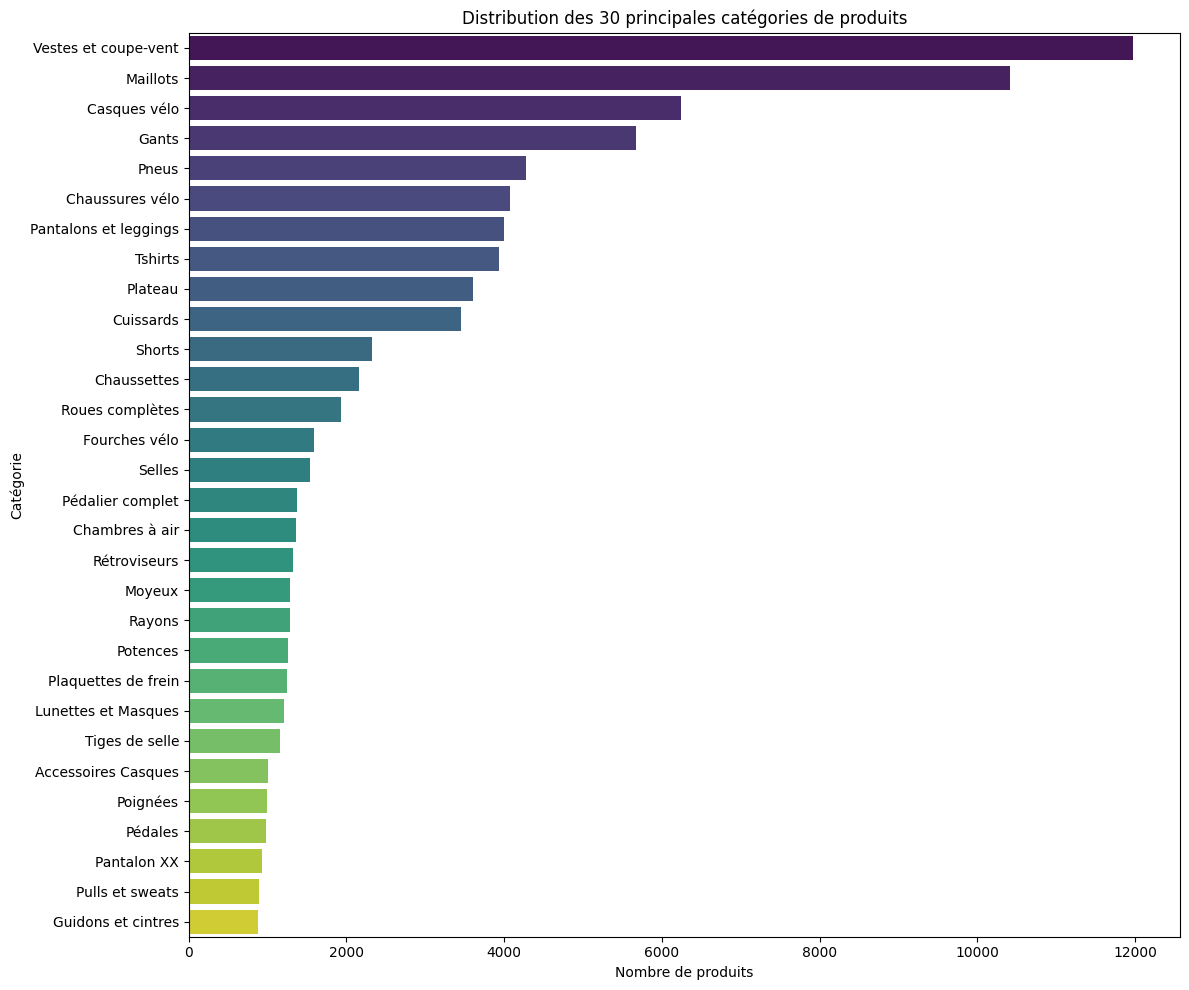

In [10]:
# On garde uniquement les colonnes utiles du df_merged
df_clean = df_merged[['product_name_decli','summary', 'description', 'brand', 'cat_name_ref']].copy()

# rename
df_clean.rename(columns={'cat_name_ref': 'category'}, inplace=True)

# On supprime les lignes où la catégorie  est null
df_clean.dropna(subset=['category'], inplace=True)

print(f"Dimensions: {df_clean.shape}")
print(df_clean.head())


print("\nAnalyse de la distribution des catégories ")

# Compter le nombre de catégories uniques
n_categories = df_clean['category'].nunique()
print(f"\n Il y a {n_categories} catégories de produits uniques à prédire.")

#les catégories les plus et les moins fréquentes
print("\n--- Top 15 des catégories les plus fréquentes ---")
print(df_clean['category'].value_counts().nlargest(15))

print("\n--- Top 15 des catégories les MOINS fréquentes ---")
print(df_clean['category'].value_counts().nsmallest(15))


# la distribution des catégories 
plt.figure(figsize=(12, 10))
sns.countplot(y='category',
              data=df_clean,
              order=df_clean['category'].value_counts().nlargest(30).index,
              palette='viridis') # 
plt.title('Distribution des 30 principales catégories de produits')
plt.xlabel('Nombre de produits')
plt.ylabel('Catégorie')
plt.tight_layout() 
plt.show()

---

## Analyse de la Distribution 
 Nombre de lignes passé de ~109k à **112 719** après fusion:  Des `id_cat` **dupliqués avec plusieurs `cat_name_ref`** dans le fichier de référence.
  - par ex id_cat 606  lié à Accessoires moteur et pull

- Pour chaque produit (`product_name_decli`), **ne garder qu’une seule catégorie**. : supprimer les doublons après fusion, en conservant la **première catégorie** rencontrée.



- **237 catégories** au total.
- `Vestes et coupe-vent`, `Maillots` = près de **25 %** des données.
- De nombreuses catégories ont **< 10 produits**, parfois **seulement 1** 

- Le modèle sera biaisé vers les classes majoritaires.
- Les classes rares introduiraient du **bruit**

donc : 
- **Filtrer les catégories trop rares**
- conserver les **catégories avec ≥ 10 produits** ( voir si c'est mieux d'augmenté le seuil ) 




Préparer le dataset avec :
- Une seule catégorie par produit
- Un filtrage des catégories trop peu représentées

---


In [11]:

# suppression des doublons
rows_before_dedup = len(df_clean)
df_clean.drop_duplicates(subset=['product_name_decli'], keep='first', inplace=True)
rows_after_dedup = len(df_clean)
print(f"{rows_before_dedup - rows_after_dedup} doublons de produits ont été supprimés.")


# Filtrer les catégories trop rares
category_counts = df_clean['category'].value_counts()

MIN_SAMPLES = 50 
categories_to_keep = category_counts[category_counts >= MIN_SAMPLES].index

rows_before_filter = len(df_clean)
df_final = df_clean[df_clean['category'].isin(categories_to_keep)].copy()
rows_after_filter = len(df_final)

print(f"Filtrage des catégories rares (seuil < {MIN_SAMPLES} produits):")
print(f"{rows_before_filter - rows_after_filter} lignes appartenant à des catégories rares ont été supprimées.")
print(f"Nombre de catégories restantes : {df_final['category'].nunique()}")
print(f"Dimensions du DataFrame final  : {df_final.shape}")


29886 doublons de produits ont été supprimés.
Filtrage des catégories rares (seuil < 50 produits):
1914 lignes appartenant à des catégories rares ont été supprimées.
Nombre de catégories restantes : 129
Dimensions du DataFrame final  : (80919, 5)


##  Bilan 

-  Suppression de ~30 000 doublons 

- 108 catégories supprimées (seuil : < 50 produits) pour 1914 lignes ( 43 avec seuil=10)

- Nombre final de catégories : 129 (vs 237 initialement)






In [13]:
import os


output_dir = 'data'
output_path = os.path.join(output_dir, 'dataset.parquet')


df_final['brand'] = df_final['brand'].astype("string")
df_final['summary'] = df_final['summary'].astype("string")
df_final['description'] = df_final['description'].astype("string")

print(f"Sauvegarde en cours vers '{output_path}'...")

os.makedirs(output_dir, exist_ok=True)

df_final.to_parquet(output_path, index=False)

print(f"Path du dataset  : {output_path}")

Sauvegarde en cours vers 'data\dataset.parquet'...
Path du dataset  : data\dataset.parquet


In [15]:
df = pd.read_parquet("data/dataset.parquet")
df.head

<bound method NDFrame.head of                                       product_name_decli summary description  \
0      AGU COMPACT RAIN HELMET COVER COMMUTER BLACK O...    <NA>        <NA>   
1      AGU COMPACT RAIN HELMET COVER COMMUTER HI-VIS ...    <NA>        <NA>   
2      AGU COMPACT RAIN HELMET COVER COMMUTER REFLECT...    <NA>        <NA>   
3      AJUSTEUR SANGLE - Piece detachee casque - Ajus...    <NA>        <NA>   
4      ANNEAU CAOUTCHOUC - Piece detachee casque - An...    <NA>        <NA>   
...                                                  ...     ...         ...   
80914  VELO MUSCULAIRE VTT LEADER FOX 29 TRION 2023 T...    <NA>        <NA>   
80915  VELO MUSCULAIRE VTT LEADER FOX 29 TRION 2023 T...    <NA>        <NA>   
80916  VELO MUSCULAIRE VTT LEADER FOX 29 TRION 2023 T...    <NA>        <NA>   
80917  VELO MUSCULAIRE VTT LEADER FOX 29 TRION 2023 T...    <NA>        <NA>   
80918  VELO MUSCULAIRE VTT LEADER FOX 29 TRION 2023 T...    <NA>        <NA>   

         

In [16]:
nb_summary_non_nuls = df['summary'].notnull().sum()
nb_description_non_nuls = df['description'].notnull().sum()

print(f"Nombre de valeurs non nulles dans 'summary' : {nb_summary_non_nuls}")
print(f"Nombre de valeurs non nulles dans 'description' : {nb_description_non_nuls}")

Nombre de valeurs non nulles dans 'summary' : 18045
Nombre de valeurs non nulles dans 'description' : 19780
